In [1]:
# Install required packages (uncomment if running in a fresh environment)
# !pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F


In [2]:
# Define CouplingLayer and RealNVP classes
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.mask = mask
        # Only one layer for s and t networks
        self.s_fc = nn.Linear(input_dim, output_dim)
        self.t_fc = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc(x_m))
        t_out = self.t_fc(x_m)
        y = x_m + (1 - self.mask) * (x * torch.exp(s_out) + t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian
    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc(y_m))
        t_out = self.t_fc(y_m)
        x = y_m + (1 - self.mask) * (y - t_out) * torch.exp(-s_out)
        return x

class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, 'Number of coupling layers should be >= 2'
        self.modules_list = []
        self.modules_list.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for _ in range(n_layers - 2):
            mask = 1 - mask
            self.modules_list.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules_list.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules_list)
    def forward(self, x):
        ldj_sum = 0
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum
    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z
print("✅ RealNVP and CouplingLayer classes defined!")


✅ RealNVP and CouplingLayer classes defined!


In [3]:
# Load MNIST, Fashion-MNIST, and CIFAR-10 datasets and set up loaders

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=False)

fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=mnist_transform)
fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=mnist_transform)
fashion_train_loader = torch.utils.data.DataLoader(fashion_train, batch_size=128, shuffle=True)
fashion_test_loader = torch.utils.data.DataLoader(fashion_test, batch_size=128, shuffle=False)

# CIFAR-10 loader is defined in the next cell


100%|██████████| 9.91M/9.91M [01:07<00:00, 147kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 228kB/s]
100%|██████████| 1.65M/1.65M [00:08<00:00, 195kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.76MB/s]
100%|██████████| 26.4M/26.4M [00:47<00:00, 561kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.11MB/s]
100%|██████████| 4.42M/4.42M [00:06<00:00, 661kB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.9MB/s]


In [ ]:
# Setup model, optimizer, and prior
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
input_dim = 28*28
output_dim = 28*28
hid_dim = 512
n_layers = 6
mask = torch.zeros(input_dim)
ones = 8
zeros = 7
step = ones + zeros
for i in range(0, input_dim, step):
    mask[i:i+ones] = 1
mask = mask.to(device)
model = RealNVP(input_dim, output_dim, hid_dim, mask, n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim).to(device), torch.eye(input_dim).to(device))


## 4. Define Training and Evaluation Functions

Define the training and evaluation functions for RealNVP.

In [ ]:
# Training function
def train_realnvp(model, train_loader, optimizer, prior, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z, log_det_jacobian = model(data)
        log_pz = prior.log_prob(z)
        loss = -torch.mean(log_pz + log_det_jacobian)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

# Evaluation function
def eval_realnvp(model, test_loader, prior, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            z, log_det_jacobian = model(data)
            log_pz = prior.log_prob(z)
            loss = -torch.mean(log_pz + log_det_jacobian)
            test_loss += loss.item()
    return test_loss / len(test_loader)

print("✅ Training and evaluation functions defined!")

✅ Training and evaluation functions defined!


In [ ]:
# --- Training and evaluation for MNIST ---
print('Training on MNIST')
# Re-initialize model and optimizer for fair comparison
model = RealNVP(input_dim, output_dim, hid_dim, mask, n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_losses_mnist = []
test_losses_mnist = []
for epoch in range(1, 2):
    train_loss = train_realnvp(model, mnist_train_loader, optimizer, prior, device)
    train_losses_mnist.append(train_loss)
    test_loss = eval_realnvp(model, mnist_test_loader, prior, device)
    test_losses_mnist.append(test_loss)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

Training on MNIST
Epoch 1 | Train Loss: -2509.5414 | Test Loss: -3106.3447
Epoch 1 | Train Loss: -2509.5414 | Test Loss: -3106.3447


In [ ]:
# --- Training and evaluation for Fashion-MNIST ---
print('Training on Fashion-MNIST')
# Re-initialize model and optimizer for fair comparison
model = RealNVP(input_dim, output_dim, hid_dim, mask, n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_losses_fashion = []
test_losses_fashion = []
for epoch in range(1, 2):
    train_loss = train_realnvp(model, fashion_train_loader, optimizer, prior, device)
    train_losses_fashion.append(train_loss)
    test_loss = eval_realnvp(model, fashion_test_loader, prior, device)
    test_losses_fashion.append(test_loss)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


Training on Fashion-MNIST
Epoch 1 | Train Loss: -2281.5803 | Test Loss: -2788.6596
Epoch 1 | Train Loss: -2281.5803 | Test Loss: -2788.6596


Reconstruction MSE error (Fashion-MNIST): 0.000000


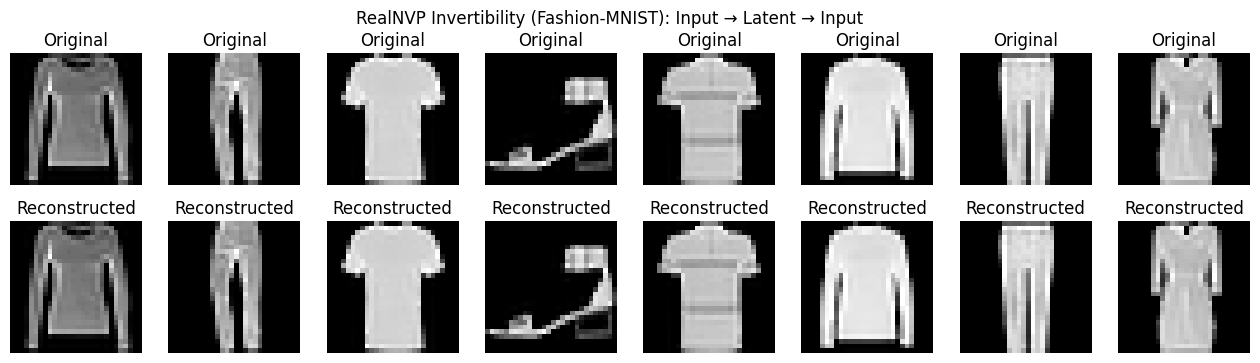

In [ ]:
# Demonstrate RealNVP invertibility on Fashion-MNIST: input -> latent -> input (reconstruction)
model.eval()
batch_flat_fashion = next(iter(fashion_train_loader))[0][:8].to(device)  # Take 8 images (already flattened)
with torch.no_grad():
    z_fashion, _ = model(batch_flat_fashion)
    x_recon_fashion = model.backward(z_fashion)
recon_error_fashion = F.mse_loss(x_recon_fashion, batch_flat_fashion).item()
print(f"Reconstruction MSE error (Fashion-MNIST): {recon_error_fashion:.6f}")
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # Reshape from flat (784,) to image (28, 28)
    axes[0, i].imshow(batch_flat_fashion[i].cpu().view(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')
    axes[1, i].imshow(x_recon_fashion[i].cpu().view(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')
plt.suptitle('RealNVP Invertibility (Fashion-MNIST): Input → Latent → Input')
plt.show()

Reconstruction MSE error: 0.000000


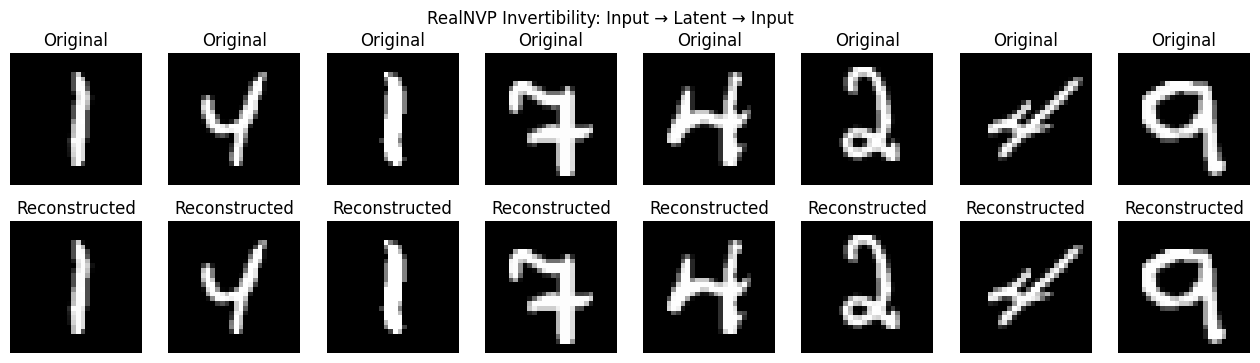

In [ ]:
# Demonstrate RealNVP invertibility: input -> latent -> input (reconstruction)
model.eval()
import torch.nn.functional as F
batch_flat = next(iter(mnist_train_loader))[0][:8].to(device)  # Take 8 images (already flattened)
with torch.no_grad():
    z, _ = model(batch_flat)
    x_recon = model.backward(z)
recon_error = F.mse_loss(x_recon, batch_flat).item()
print(f"Reconstruction MSE error: {recon_error:.6f}")
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # Reshape from flat (784,) to image (28, 28)
    axes[0, i].imshow(batch_flat[i].cpu().view(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')
    axes[1, i].imshow(x_recon[i].cpu().view(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')
plt.suptitle('RealNVP Invertibility: Input → Latent → Input')
plt.show()